# POET - Demo Notebook

This notebook is to:
* Run inference on sample image
* Plot predicted keypoints and centers

## Preliminaries


In [1]:
import numpy as np

from PIL import Image
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
import torchvision.transforms as T
torch.set_grad_enabled(False);

import os
import sys
sys.path.append("..") # Adds higher directory to python modules path

In [2]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transPIL = T.ToPILImage()

def rescale_kpts(out_kpts, size):
    img_w, img_h = size
    b = out_kpts.clone()
    
    out_kpts[:, 2::3] = (out_kpts[:, 2::3] - 0.5) * 2
    out_kpts[:, 3::3] = (out_kpts[:, 3::3] - 0.5) * 2
    
    img_w = torch.tensor([img_w], dtype=torch.float32).to(device)
    img_h = torch.tensor([img_h], dtype=torch.float32).to(device)
    
    b[:,0] = out_kpts[:,0] * img_w
    b[:,1] = out_kpts[:,1] * img_h
    b[:,2::3] = out_kpts[:,2::3] * img_w + b[:,0].unsqueeze(-1)
    b[:,3::3] = out_kpts[:,3::3] * img_h + b[:,1].unsqueeze(-1)
    return b

## Pose estimation - loading POET model

In [3]:
chkpt_path = '../checkpoints/checkpoint.pth'

In [4]:
from models.backbone import Backbone, Joiner
from models.poet import POET, PostProcess
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer


def make_poet(pretrained=False, backbone_name="resnet50", dilation5=False, num_classes=2, return_postprocessor=False):
    hidden_dim = 256
    backbone = Backbone(backbone_name, train_backbone=False, return_interm_layers=False,
                        dilation5=dilation5, dilation4=False)
    pos_enc = PositionEmbeddingSine(hidden_dim // 2, normalize=True)
    backbone_with_pos_enc = Joiner(backbone, pos_enc)
    backbone_with_pos_enc.num_channels = backbone.num_channels
    transformer = Transformer(d_model=hidden_dim, return_intermediate_dec=True)
    poet = POET(backbone_with_pos_enc, transformer, num_classes=num_classes, num_queries=25, aux_loss=True)
    if pretrained:
        checkpoint = torch.load(chkpt_path, map_location="cpu")
        poet.load_state_dict(checkpoint["model"])
    if return_postprocessor:
        return poet, PostProcess()
    
    return poet

In [5]:
device = torch.device('cuda')

model = make_poet(pretrained=True)
model.eval();
model.train(False)

model = model.to(device)

### Import visualization script

In [6]:
from visualization import VisImage, KeypointsVis, CenterVis, VisibilityVis

## Load sample image and get POET predictions

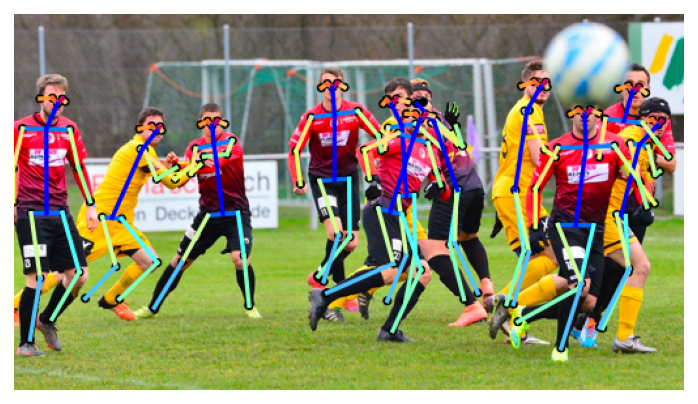

In [7]:
im = cv2.imread('sample_image.png') 
im = transPIL(im)
img = transform(im).unsqueeze(0)

# propagate through the model
with torch.no_grad():
    outputs = model(img.to(device))

probas = outputs['pred_logits'].softmax(-1)[0, :, 1]

threshold = 0.7
keep = probas >= threshold

kpts_scaled = rescale_kpts(outputs['pred_kpts'][0, keep], im.size)
Keypoints = KeypointsVis(image = np.asarray(im))
for idx in range(len(kpts_scaled)):
    a = Keypoints.draw_and_connect_keypoints(keypoints = kpts_scaled[idx, 2:].reshape(-1,3))
plt.axis("off")
plt.imshow(cv2.cvtColor(a.get_image(), cv2.COLOR_BGR2RGB))

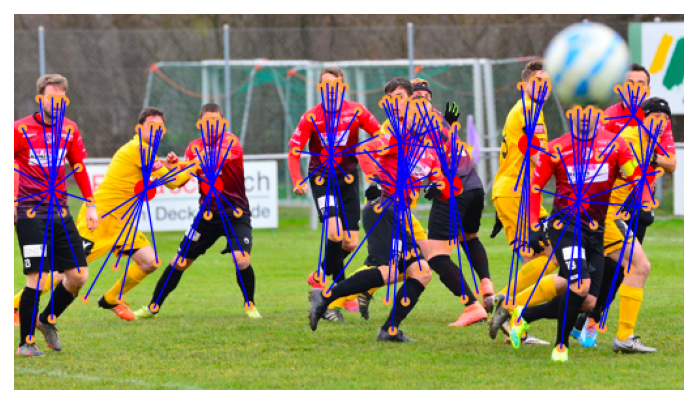

In [8]:
Keypoints = CenterVis(image = np.asarray(im))
for idx in range(len(kpts_scaled)):
    a = Keypoints.draw_and_connect_keypoints(keypoints = kpts_scaled[idx])
    a.ax.add_patch(mpl.patches.Circle(kpts_scaled[idx][:2], radius=8, fill=True, color=(0, 0, 1.0)))
plt.axis("off")
plt.imshow(cv2.cvtColor(a.get_image(), cv2.COLOR_BGR2RGB))